# Análisis de Bitcoin
Este script automatiza la recopilación, análisis y visualización de datos del precio de Bitcoin utilizando Python.

**Recopilación de Datos:** Descarga el precio histórico de Bitcoin de los últimos 7 días en intervalos de 5 minutos a través de la API de Yahoo Finance. Luego, realiza scraping en CoinMarketCap para extraer el precio actual y la tendencia de Bitcoin.

**Análisis y Toma de Decisiones:** Basándose en el precio actual y la tendencia, el script determina si se debe comprar, vender o no realizar ninguna acción.

**Automatización:** Todo el proceso se ejecuta en un bucle que se repite cada 5 minutos, actualizando automáticamente los datos y la visualización.

# 1. Configuración del ambiente

In [1]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

/bin/bash: python: command not found
------
Name: pandas
Version: 2.0.3
------
Name: numpy
Version: 1.24.4
------
Name: matplotlib
Version: 3.7.5


## 1.1 importar librerias y definir variables globales

In [2]:
import datetime
import pandas as pd
import numpy as np
import yfinance as yf

In [3]:
# Definir variables globales
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

# 2. Obtención de datos

## 2.1 Precios historico del bitcoin

In [4]:
def importar_base_bitcoin():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

    symbol = 'BTC-USD'

    # fecha de inicio y fin para los últimos 7 días
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=7)

    # Descarga el precio histórico del bitcoin en intervalos de 5 minutos
    data = yf.download(symbol, start=start_date, end=end_date, interval='5m')

    # Pausa durante 5 minutos antes de la proxima actualización
    #time.sleep(300)  # 300 segundos = 5 minutos
    
    df_bitcoin = pd.DataFrame(data)
    #print(df_bitcoin)
    
importar_base_bitcoin()


[*********************100%***********************]  1 of 1 completed


## 2.2 Scraping Precio bitcoin de coinmarketcap

In [5]:
def extraer_tendencias():
    global precio_actual, tendencia
    
    from bs4 import BeautifulSoup
    import requests

    ua = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36 Edg/92.0.902.62 (compatible; Linux; Ubuntu; MacOS; Windows)"}
    website = 'https://coinmarketcap.com/'
    
    response = requests.get(website)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extraer el precio de Bitcoin
    precio_actual = soup.find('div', class_='sc-b3fc6b7-0 dzgUIj').text
    precio_actual = float(precio_actual.replace('$', '').replace(',', ''))

    # Extraer variación de porcentaje
    variacion = soup.find('span', class_='sc-a59753b0-0 ivvJzO').text.strip('%')
    variacion = float(variacion)
    
    # Determinar tendencia en base al porcentaje
    if variacion < 0:
        tendencia = 'baja'
    else:
        tendencia = 'alta'
    
extraer_tendencias()

print(f"Precio actual: {precio_actual}, Tendencia: {tendencia}")


Precio actual: 69630.28, Tendencia: alta


# 3. Limpieza de datos

In [6]:
def limpieza_datos():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
    import numpy as np

    df_bitcoin_limpio = df_bitcoin.copy()

    # Identificar valores duplicados en el índice
    valores_duplicados_en_indice = df_bitcoin_limpio.index.duplicated()
    #print(valores_duplicados_en_indice)

    # Eliminar los valores duplicados en el índice
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
    #df_bitcoin_limpio = df_bitcoin_limpio.drop_duplicates(keep='first')

    # verificar y ver los valores nulos en la columna 
    df_bitcoin_nulos = df_bitcoin_limpio['Close'].isnull().sum()
    #print("Valores nulos en Close:", df_bitcoin_nulos)
    # Elimina valores nulos en la columna Close
    df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])


    # Filtra los registros con Volumen mayor a 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    # crea un grafico de caja de la columna close
    #import matplotlib.pyplot as plt
    #plt.figure(figsize=(8, 6))
    #plt.boxplot(df_bitcoin_limpio['Close'], vert=True)
    #plt.ylabel('Precio de Cierre (Close)')
    #plt.title('Boxplot del Precio de Cierre de Bitcoin')
    #plt.show()

    # Calcula los cuartiles Q1 y Q3 
    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    #print("cuantil 1 :", Q1)
    #print("cuantil 3 :", Q3)
    # Filtra para tener un precio de cierre entre Q1 y Q3
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]
    # grafico el df con los valores entre q1 y q3
    #plt.figure(figsize=(8, 6))
    #plt.boxplot(df_bitcoin_limpio['Close'], vert=True)
    #plt.ylabel('Precio de Cierre (Close)')
    #plt.title('Boxplot del Precio de Cierre de Bitcoin entre Q1 y Q3')
    #plt.show()

    # Calcula el precio promedio de la columna close
    media_bitcoin = df_bitcoin_limpio['Close'].mean()
    #print("Precio promedio bitcoin: ", media_bitcoin)
limpieza_datos()  

# 4. Tomar decisiones

Se rellena la variable algoritmo_decision con el valor resultante del siguiente criterio de decisión:

- Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.
- Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.
- Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda el valor 'Ninguna'.

In [7]:
def tomar_decisiones():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
    # Obtener el último precio de cierre del DataFrame
    precio_actual = df_bitcoin['Close'].iloc[-1]
    
    # Lógica de toma de decisiones
    if precio_actual >= media_bitcoin and tendencia == 'baja':
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Ninguna'
    
    # Imprimir la decisión
    print(f"Precio actual: {precio_actual}, Precio promedio: {media_bitcoin}, Tendencia: {tendencia}, Decisión: {algoritmo_decision}")
tomar_decisiones()

Precio actual: 67933.296875, Precio promedio: 67422.90841568274, Tendencia: alta, Decisión: Ninguna


# 5. Visualización

Precio actual: 67933.296875, Precio promedio: 67422.90841568274, Tendencia: alta, Decisión: Ninguna


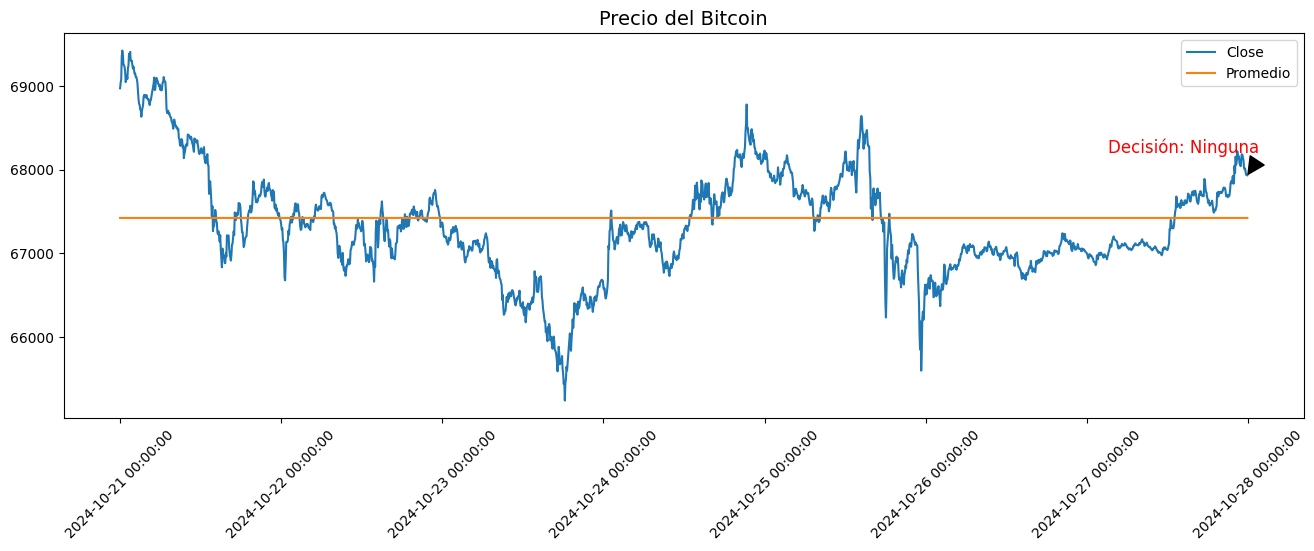

In [8]:
def visualizacion():
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    global df_bitcoin, media_bitcoin, algoritmo_decision
    
    # Crear una nueva columna en df_bitcoin y llenar con los valores del promedio
    df_bitcoin['Promedio'] = media_bitcoin
    
    # Configurar el tamaño del gráfico
    plt.figure(figsize=(16, 5))
    
    # Dibujar una línea con los datos de la columna Close usando el índice como eje x
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Close')
    
    # Dibujar una línea con los datos de la columna Promedio
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio')
    
    # Agregar un título al gráfico
    plt.title('Precio del Bitcoin', fontsize=14, color='black')
    
    # Mostrar un mensaje con la decisión en el gráfico
    plt.annotate(f'Decisión: {algoritmo_decision}', 
                 xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),  # posición en el gráfico
                 xytext=(-100, 20),  # desplazamiento del texto
                 textcoords='offset points',  # usar el desplazamiento en puntos
                 fontsize=12, color='red', 
                 ha='left', va='center',  # alineación 
                 arrowprops=dict(facecolor='black', shrink=0.05))  # agregar una flecha
    
    # Configurar el formato de las fechas en el eje x
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    
    # Rotar las etiquetas del eje x para mejorar la legibilidad
    plt.xticks(rotation=45)
    
    # Agregar una leyenda para las líneas
    plt.legend()
    
    # Mostrar el gráfico 
    plt.show()

# Llamamos a la función de toma de decisiones
tomar_decisiones()

# Llamamos a la función de visualización
visualizacion()


# 6. Automatización

[*********************100%***********************]  1 of 1 completed


Precio actual: 67918.15, Precio promedio: 62918.98563415751, Tendencia: alta, Decisión: Ninguna


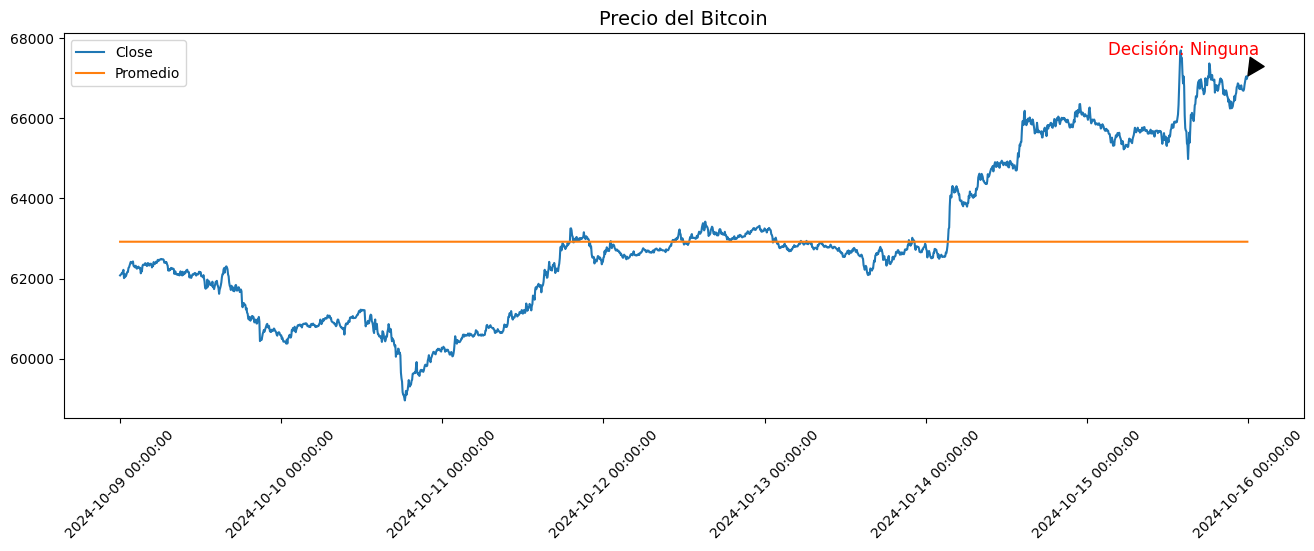

KeyboardInterrupt: 

In [9]:
from IPython.display import clear_output
import time

while True:
    try:
        clear_output(wait=True)  # borrar la salida anterior
        
        importar_base_bitcoin()
        extraer_tendencias()
        limpieza_datos()
        tomar_decisiones()
        
        visualizacion()
        
        time.sleep(300)  # actializa cada 5 minutos
    except Exception as e:
        print(f"Error: {e}")  # imprimir el error 





- Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.
- Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.
- Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda el valor 'Ninguna'.


